In [1]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

# 1. The LASSO and Boosting for Regression

## 1.(a) Download the Communities and Crime data

In [2]:
# declare the path to files needed
data_file = "../data/communities.csv"
attr_file = "../data/communities_names.txt"

In [3]:
# parse the communities_names.txt file to find attribute names
attrs = []
with open(attr_file, 'r') as f:
    lines = f.readlines()
    for line in lines:
        if (line.startswith('@attribute')):
            attrs.append(line.split(" ")[1])
# 128 attibutes expected: 122 predictive, 5 non-predictive and 1 goal
print("Totally", len(attrs), "attributes.")
print(attrs[:5], "are 5 non-predictive attributes should be ignored")

Totally 128 attributes.
['state', 'county', 'community', 'communityname', 'fold'] are 5 non-predictive attributes should be ignored


In [4]:
commt_data = pd.read_csv(data_file, sep=",", header=None, names=attrs, na_values='?')
commt_data = commt_data.iloc[:, 5:]

## 1.(b) Use a data imputation technique to deal with the missing values in the data set. 

In [5]:
nan_statistic = commt_data.apply(lambda col : sum(col.isna()) / len(col), axis=0)
nan_statistic.loc[nan_statistic > 0]

OtherPerCap             0.000502
LemasSwornFT            0.840020
LemasSwFTPerPop         0.840020
LemasSwFTFieldOps       0.840020
LemasSwFTFieldPerPop    0.840020
LemasTotalReq           0.840020
LemasTotReqPerPop       0.840020
PolicReqPerOffic        0.840020
PolicPerPop             0.840020
RacialMatchCommPol      0.840020
PctPolicWhite           0.840020
PctPolicBlack           0.840020
PctPolicHisp            0.840020
PctPolicAsian           0.840020
PctPolicMinor           0.840020
OfficAssgnDrugUnits     0.840020
NumKindsDrugsSeiz       0.840020
PolicAveOTWorked        0.840020
PolicCars               0.840020
PolicOperBudg           0.840020
LemasPctPolicOnPatr     0.840020
LemasGangUnitDeploy     0.840020
PolicBudgPerPop         0.840020
dtype: float64

We can see that there are some features are missed for the majority of samples. As it said in the data description in `communities_names.txt`

> A limitation was that the LEMAS survey was of the police departments with at least 100 
officers, plus a random sample of smaller departments. For our purposes, communities 
not found in both census and crime datasets were omitted. Many communities are missing 
LEMAS data.

Thus, those attributes are not missed in accident but systematically. It could be meaningless if we still apply data imputation to them. **Rather than that, I think the proper way is to ignore those features where the missed ones are majority. While, for the feature with minor missing (`OtherPerCap`), I use the mean to do the data imputation.**

In [6]:
# drop the columns that missing values have propotion over 0.2
filtered_commt_data = commt_data.loc[:, nan_statistic.values < 0.2]
column_names = [f for i, f in enumerate(attrs[5:]) if nan_statistic.iloc[i] < 0.2]

In [7]:
from sklearn.impute import SimpleImputer
"""
Doc reference: 
https://scikit-learn.org/stable/modules/impute.html
https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer
"""
# get the data from csv file and perform data imputation with mean
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
filtered_commt_data = pd.DataFrame(imp.fit_transform(filtered_commt_data), 
                                   columns=filtered_commt_data.columns)
# split train dataset
train_set = filtered_commt_data.iloc[:1495, :]
test_set = filtered_commt_data.iloc[1495:, :]
# train_set = pd.DataFrame(imp.fit_transform(train_set), columns=column_names)
# test_set = pd.DataFrame(imp.fit_transform(test_set), columns=column_names)

In [8]:
train_set

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490,0.00,0.59,0.01,0.69,1.00,0.07,0.41,0.28,0.23,0.57,...,0.61,0.46,0.75,0.72,0.78,0.02,0.14,0.22,0.00,0.03
1491,0.16,0.62,0.03,0.74,0.48,0.42,0.44,0.57,0.40,0.25,...,0.60,0.44,0.39,0.68,0.67,0.07,0.40,0.14,0.61,0.20
1492,0.01,0.36,0.95,0.24,0.03,0.01,0.44,0.42,0.27,0.63,...,0.02,0.86,0.61,0.77,0.81,0.03,0.12,0.01,0.00,0.30
1493,0.06,0.53,0.01,0.98,0.05,0.01,0.40,0.40,0.24,0.29,...,0.08,0.78,0.63,0.70,0.82,0.08,0.15,0.02,0.00,0.03


In [9]:
test_set

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
1495,0.00,0.20,0.03,0.91,0.23,0.05,0.15,0.19,0.09,0.42,...,0.33,0.45,0.57,0.56,0.74,0.01,0.23,0.73,0.00,0.12
1496,0.00,0.55,0.13,0.78,0.15,0.36,0.48,0.53,0.30,0.10,...,0.17,0.45,0.52,0.59,0.57,0.01,0.18,0.02,0.00,0.11
1497,0.00,0.52,0.04,0.59,0.05,0.62,0.84,0.78,0.75,0.43,...,0.19,0.47,0.37,0.38,0.49,0.01,0.18,0.00,0.00,0.12
1498,0.04,0.51,0.07,0.92,0.09,0.03,0.38,0.47,0.27,0.35,...,0.10,0.62,0.70,0.75,0.64,0.06,0.13,0.16,0.00,0.06
1499,0.03,0.59,0.20,0.75,0.19,0.10,0.38,0.62,0.35,0.11,...,0.22,0.33,0.16,0.06,0.27,0.03,0.23,0.06,0.00,0.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,...,0.22,0.28,0.34,0.48,0.39,0.01,0.28,0.05,0.00,0.09
1990,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,...,0.53,0.25,0.17,0.10,0.00,0.02,0.37,0.20,0.00,0.45
1991,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,0.54,...,0.25,0.68,0.61,0.79,0.76,0.08,0.32,0.18,0.91,0.23
1992,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,0.41,...,0.45,0.64,0.54,0.59,0.52,0.03,0.38,0.33,0.22,0.19


## 1.(c) Plot a correlation matrix for the features in the data set.

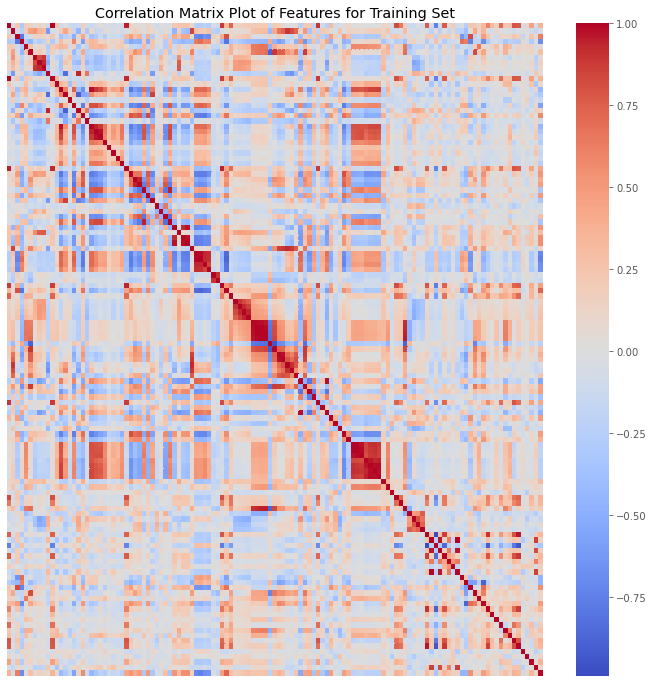

In [10]:
# plot on entire dataset (non-filtered one)
fit, axes = plt.subplots(figsize=(12, 12))
sns.heatmap(commt_data.corr(), cmap='coolwarm',
            xticklabels=False, yticklabels=False, ax=axes)
plt.title("Correlation Matrix Plot of Features for Training Set")
plt.show()

## 1.(d) Calculate the Coefficient of Variation CV for each feature

In [11]:
coef_of_vari = commt_data.apply(lambda col : col.std() / col.mean(), axis=0)
print(coef_of_vari)

population             2.203503
householdsize          0.353298
racepctblack           1.410920
racePctWhite           0.323782
racePctAsian           1.359162
                         ...   
LemasPctPolicOnPatr    0.306251
LemasGangUnitDeploy    0.921372
LemasPctOfficDrugUn    2.555266
PolicBudgPerPop        0.844368
ViolentCrimesPerPop    0.979015
Length: 123, dtype: float64


## 1.(e) Pick $\lfloor\sqrt{128}\rfloor$ features with highest CV, and make scatter plots and box plots for them.

In [12]:
num_features = int(np.floor(np.sqrt(128)))
highCVfeats = coef_of_vari.sort_values(ascending=False)[:num_features]
highCVfeats

NumStreet              4.407702
NumInShelters          3.485481
NumIlleg               2.994196
NumImmig               2.900497
LemasPctOfficDrugUn    2.555266
NumUnderPov            2.304970
population             2.203503
numbUrban              2.001744
LemasSwornFT           1.984599
PctPolicAsian          1.979371
HousVacant             1.958780
dtype: float64

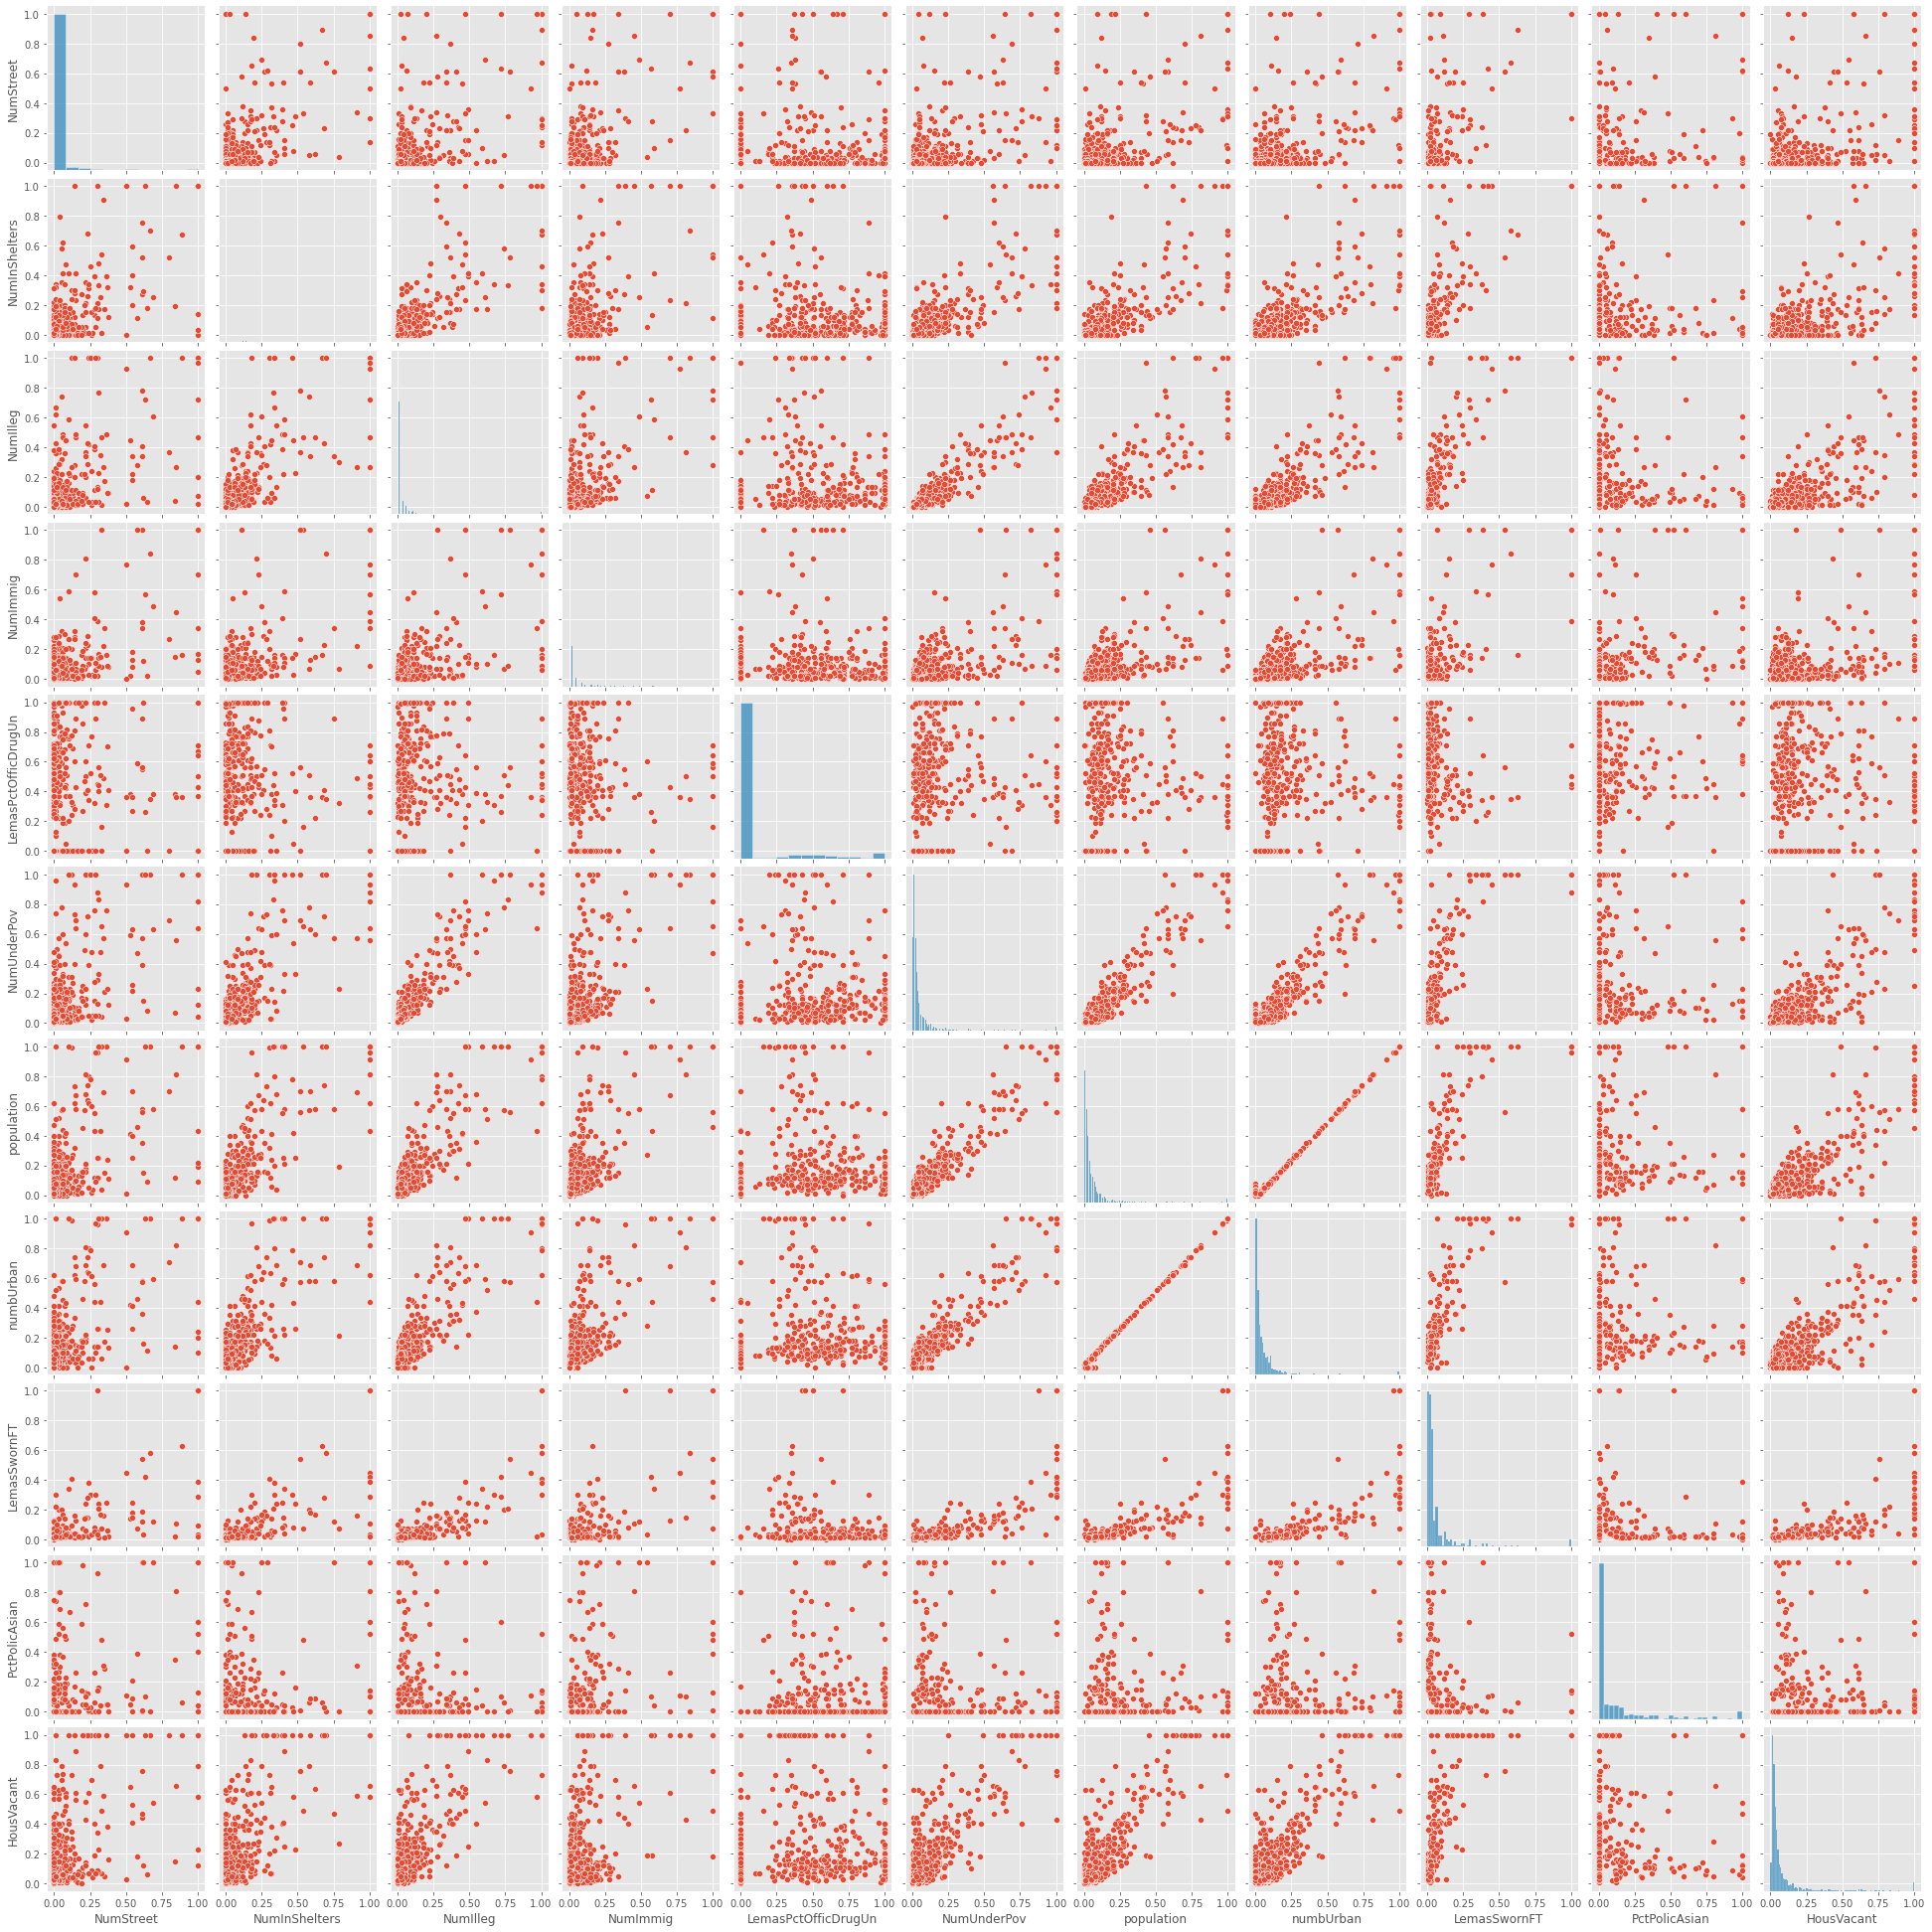

In [13]:
selected_cols = highCVfeats.index.tolist()
sns.pairplot(commt_data[selected_cols])
plt.show()

It's hard to draw a conclusion of significance of those features just by scatter plots.

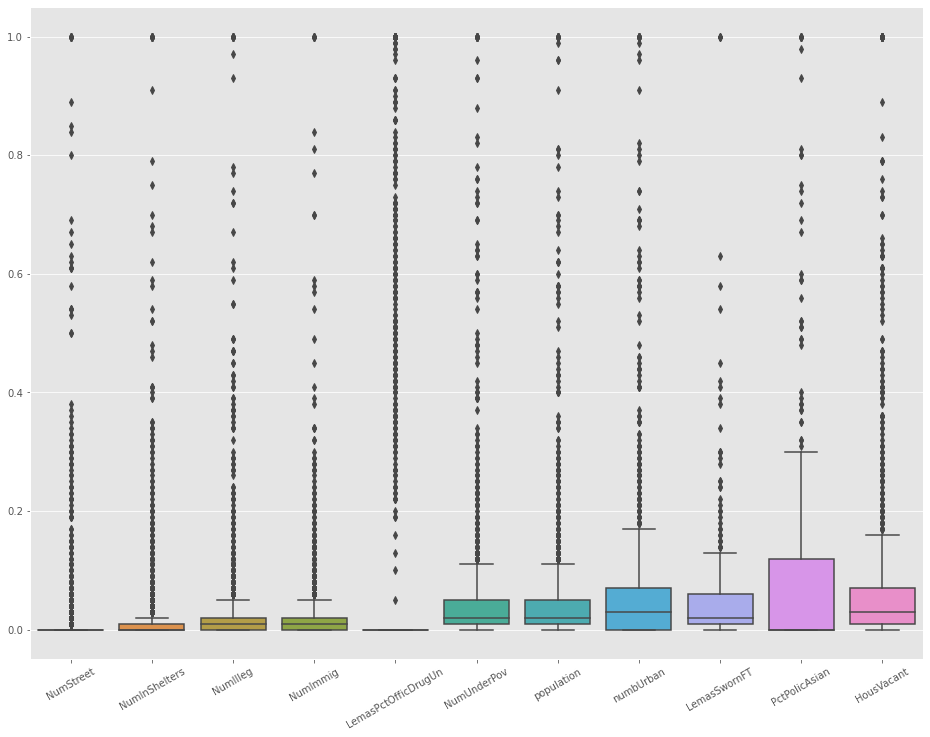

In [14]:
fig, axes = plt.subplots(figsize=(16, 12))
sns.boxplot(data=commt_data[selected_cols], ax=axes)
plt.xticks(rotation=30)
plt.show()

In [15]:
model_test_mse = {}

## 1.(f) Fit a linear model using least squares to the training set and report the test error.

In [16]:
# use OLS model
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

train_X = train_set.iloc[:, :-1]
train_Y = train_set.iloc[:, -1]

test_X = test_set.iloc[:, :-1]
test_Y = test_set.iloc[:, -1]

# train_X_inter = sm.add_constant(train_X)
# olsreg = sm.OLS(train_Y, train_X_inter).fit()
# print(olsreg.summary())

olsreg = LinearRegression()
olsreg.fit(train_X, train_Y)
test_pred = olsreg.predict(test_X)
test_mse = mean_squared_error(test_Y, test_pred)
model_test_mse["OLS"] = test_mse
print("OLS Linear Regression's test MSE:", test_mse)

OLS Linear Regression's test MSE: 0.017844644706157826


## 1.(g) Fit a ridge regression model on the training set, with λ chosen by cross-validation. Report the test error obtained.

In [17]:
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeCV
"""
Doc references:
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html
https://scikit-learn.org/stable/modules/model_evaluation.html
"""

# create k-fold cross validation splitter
splitter = KFold(5, shuffle=True, random_state=1495)

# create a list of alpha ooptions
alphas = [10 ** i for i in range(-5, 6)]

# create ridge model
ridge_model = RidgeCV(alphas=alphas, 
                      cv=splitter, 
                      scoring='neg_mean_squared_error')
ridge_model.fit(train_X, train_Y)
print("Choose alpha = {}".format(ridge_model.alpha_))

Choose alpha = 1.0


In [18]:
test_pred = ridge_model.predict(test_X)
test_mse = mean_squared_error(test_Y, test_pred)
model_test_mse["Ridge_Regression"] = test_mse
print("Ridge Regression's test MSE:", test_mse)

Ridge Regression's test MSE: 0.017502306931091567


## 1.(h) Fit a LASSO model on the training set, with λ chosen by cross-validation. 

In [19]:
from sklearn.linear_model import LassoCV
"""
Doc references:
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html
"""

# Lasso without standardization
lasso_model = LassoCV(alphas=alphas, 
                      cv=splitter)
lasso_model.fit(train_X, train_Y)
print("Choose alpha = {}".format(lasso_model.alpha_))

Choose alpha = 0.0001


In [20]:
test_pred = lasso_model.predict(test_X)
test_mse = mean_squared_error(test_Y, test_pred)
model_test_mse["Lasso_w/o_std"] = test_mse
print("Without standardization, Lasso Regression's test MSE:", test_mse)
lasso_selecte_feature = pd.Series(data=lasso_model.coef_[lasso_model.coef_!=0],
                                  index=test_X.columns[lasso_model.coef_!=0])
print(lasso_selecte_feature)

Without standardization, Lasso Regression's test MSE: 0.01758385221993978
racepctblack           0.275387
racePctAsian          -0.014810
agePct12t21            0.078213
agePct12t29           -0.279285
agePct65up             0.011939
                         ...   
PctSameCity85          0.028100
LandArea               0.016662
PopDens                0.007536
PctUsePubTrans        -0.046075
LemasPctOfficDrugUn    0.009125
Length: 67, dtype: float64


In [21]:
from sklearn.preprocessing import StandardScaler
"""
Doc reference:
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
"""
# Lasso with standardization

# standardization of features
scaler = StandardScaler()
std_train_X = scaler.fit_transform(train_X)
std_test_X = scaler.fit_transform(test_X)

std_train_X = pd.DataFrame(data=std_train_X, columns=train_X.columns)
std_test_X = pd.DataFrame(data=std_test_X, columns=test_X.columns)

# re-fit a Lasso model
lasso_model = LassoCV(alphas=alphas, 
                      cv=splitter)
lasso_model.fit(std_train_X, train_Y)
print("Choose alpha = {}".format(lasso_model.alpha_))

Choose alpha = 0.001


In [22]:
test_pred = lasso_model.predict(std_test_X)
test_mse = mean_squared_error(test_Y, test_pred)
model_test_mse["Lasso_w_std"] = test_mse
print("With standardization, Lasso Regression's test MSE:", test_mse)
lasso_selecte_feature = pd.Series(data=lasso_model.coef_[lasso_model.coef_!=0],
                                  index=test_X.columns[lasso_model.coef_!=0])
print(lasso_selecte_feature)

With standardization, Lasso Regression's test MSE: 0.017710939343910607
population              -0.001318
racepctblack             0.067537
agePct12t21              0.005808
agePct12t29             -0.027356
pctUrban                 0.015397
pctWWage                -0.009828
pctWFarmSelf             0.003414
pctWInvInc              -0.015813
pctWSocSec               0.005282
pctWPubAsst              0.003295
pctWRetire              -0.014889
whitePerCap             -0.004651
blackPerCap             -0.003123
indianPerCap            -0.005016
AsianPerCap              0.004814
OtherPerCap              0.003792
HispPerCap               0.002939
PctPopUnderPov          -0.021052
PctLess9thGrade         -0.000525
PctEmploy                0.015509
MalePctDivorce           0.016556
MalePctNevMarr           0.015150
FemalePctDiv            -0.001859
PctKids2Par             -0.041631
PctYoungKids2Par        -0.008787
PctTeen2Par             -0.000512
PctWorkMom              -0.020014
NumIlleg  

## 1.(i) Fit a PCR model on the training set, with M (the number of principal compo- nents) chosen by cross-validation.

In [23]:
from sklearn.decomposition import PCA
"""
Doc references:
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_fa_model_selection.html
"""

def PCRCV(train_X, train_Y, fold, dim):
    valid_err = 0
    # create k-fold cross validation splitter
    splitter = KFold(fold, shuffle=True, random_state=1495)
    for train_idx, valid_idx in splitter.split(train_X):
        # split train and validation set
        cur_trainX = train_X.iloc[train_idx, :]
        cur_trainY = train_Y.iloc[train_idx]
        cur_validX = train_X.iloc[valid_idx, :]
        cur_validY = train_Y.iloc[valid_idx]
        # perform PCA
        pca = PCA(n_components=dim).fit(cur_trainX)
        pca_train = pca.transform(cur_trainX)
        pca_valid = pca.transform(cur_validX)
        # ordinary leaste square regression using data after PCA
        olsreg = LinearRegression()
        olsreg.fit(pca_train, cur_trainY)
        valid_pred = olsreg.predict(pca_valid)
        valid_mse = mean_squared_error(cur_validY, valid_pred)
        #print("OLS Linear Regression's validation MSE:", test_mse)
        valid_err += valid_mse
    return valid_err / fold

In [24]:
# try different dimension of PCA
avg_valid_err = []
for m in range(1, len(train_X.columns) + 1):
    valid_err = PCRCV(train_X, train_Y, 5, m)
    avg_valid_err.append((m, valid_err))

# sort the list and get the minimum validation error
avg_valid_err.sort(key=lambda x: x[1])
print("When M = {}, the validation mse reach minimum of {}.".format(avg_valid_err[0][0],
                                                               avg_valid_err[0][1]))

When M = 87, the validation mse reach minimum of 0.019228522557120896.


In [25]:
# create a PCA model using best M
pca = PCA(n_components=87).fit(train_X)

# apply PCA to train and test set
pca_train = pca.transform(train_X)
pca_test = pca.transform(test_X)

# linear regression with PCA results
olsreg = LinearRegression().fit(pca_train, train_Y)
test_pred = olsreg.predict(pca_test)
test_mse = mean_squared_error(test_Y, test_pred)
model_test_mse["PCR"] = test_mse
print("PCR model's test MSE:", test_mse)

PCR model's test MSE: 0.017874126495056476


## 1.(j) Fit a boosting tree to the data

In [26]:
"""
Doc references:
https://xgboost.readthedocs.io/en/latest/get_started.html
https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=dmatrix#xgboost.DMatrix
https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=cv#xgboost.cv
https://machinelearningmastery.com/evaluate-gradient-boosting-models-xgboost-python/
"""

import xgboost as xgb
from sklearn.model_selection import cross_val_score

In [27]:
''' This section will take some time to finish'''
# convert data to Data Matrix defiened in xgboost gramework
train_Dmatrix = xgb.DMatrix(data=train_X, label=train_Y)
test_Dmatrix = xgb.DMatrix(data=test_X)

avg_valid_err = []
alphas = [10 ** i for i in range(-10, 11)]

# create k-fold cross validation splitter
splitter = KFold(5, shuffle=True, random_state=1495)

# perform cross-validation to find best alpha
for alpha in alphas:
#     params = {"obj":"reg:squarederror",
#               "alpha": alpha,
#               "num_boost_round":30,
#               "early_stopping_rounds":10}
#     cvres = xgb.cv(params=params, dtrain=train_Dmatrix, nfold=5, seed=1495)
#     avg_valid_err.append((alpha, cvres["test-rmse-mean"].iloc[-1]))
    #print(cvres)
    
    xgb_model = xgb.XGBRegressor(objective="reg:squarederror", reg_alpha=alpha)
    cvres = cross_val_score(xgb_model, train_X, train_Y, cv=splitter, 
                            scoring="neg_mean_squared_error")
    avg_valid_err.append((alpha, np.abs(cvres.mean())))

# sort the list and get the minimum validation error
avg_valid_err.sort(key=lambda x: x[1])
print("When alpha = {}, the validation mse reaches minimum of {}.".format(avg_valid_err[0][0],
                                                               avg_valid_err[0][1]))

When alpha = 0.1, the validation mse reaches minimum of 0.020373637387641738.


In [28]:
# xgboost model with best value of alpha
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', reg_alpha=0.1).fit(train_X, train_Y)
test_pred = xgb_model.predict(test_X)
test_mse = mean_squared_error(test_Y, test_pred)
model_test_mse["XGBoost"] = test_mse
print("XGBoost model's test MSE:", test_mse)

XGBoost model's test MSE: 0.016625718312266814


In [29]:
model_test_mse = pd.DataFrame.from_dict(model_test_mse, orient='index', columns=['test_mse'])
model_test_mse

,test_mse
OLS,0.017845
Ridge_Regression,0.017502
Lasso_w/o_std,0.017584
Lasso_w_std,0.017711
PCR,0.017874
XGBoost,0.016626


# 2. Tree-Based Methods

## 2.(a) Download the APS Failure data

In [30]:
aps_train_path = '../data/aps_failure_training_set.csv'
aps_test_path = '../data/aps_failure_test_set.csv'

aps_train = pd.read_csv(aps_train_path, skiprows=20, na_values = 'na')
aps_test = pd.read_csv(aps_test_path, skiprows=20, na_values = 'na')
aps_all = pd.concat([aps_train, aps_test])

In [31]:
aps_train

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,neg,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,neg,60874,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,neg,153002,NaN,6.640000e+02,186.0,0.0,0.0,0.0,0.0,0.0,...,998500.0,566884.0,1290398.0,1218244.0,1019768.0,717762.0,898642.0,28588.0,0.0,0.0
59996,neg,2286,NaN,2.130707e+09,224.0,0.0,0.0,0.0,0.0,0.0,...,10578.0,6760.0,21126.0,68424.0,136.0,0.0,0.0,0.0,0.0,0.0
59997,neg,112,0.0,2.130706e+09,18.0,0.0,0.0,0.0,0.0,0.0,...,792.0,386.0,452.0,144.0,146.0,2622.0,0.0,0.0,0.0,0.0
59998,neg,80292,NaN,2.130706e+09,494.0,0.0,0.0,0.0,0.0,0.0,...,699352.0,222654.0,347378.0,225724.0,194440.0,165070.0,802280.0,388422.0,0.0,0.0


In [32]:
aps_test

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,60,0.0,2.000000e+01,12.0,0.0,0.0,0.0,0.0,0.0,...,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0
1,neg,82,0.0,6.800000e+01,40.0,0.0,0.0,0.0,0.0,0.0,...,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0
2,neg,66002,2.0,2.120000e+02,112.0,0.0,0.0,0.0,0.0,0.0,...,495076.0,380368.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0,0.0,0.0
3,neg,59816,NaN,1.010000e+03,936.0,0.0,0.0,0.0,0.0,0.0,...,540820.0,243270.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0,0.0,0.0
4,neg,1814,NaN,1.560000e+02,140.0,0.0,0.0,0.0,0.0,0.0,...,7646.0,4144.0,18466.0,49782.0,3176.0,482.0,76.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,neg,81852,NaN,2.130706e+09,892.0,0.0,0.0,0.0,0.0,0.0,...,632658.0,273242.0,510354.0,373918.0,349840.0,317840.0,960024.0,25566.0,0.0,0.0
15996,neg,18,0.0,5.200000e+01,46.0,8.0,26.0,0.0,0.0,0.0,...,266.0,44.0,46.0,14.0,2.0,0.0,0.0,0.0,0.0,0.0
15997,neg,79636,NaN,1.670000e+03,1518.0,0.0,0.0,0.0,0.0,0.0,...,806832.0,449962.0,778826.0,581558.0,375498.0,222866.0,358934.0,19548.0,0.0,0.0
15998,neg,110,NaN,3.600000e+01,32.0,0.0,0.0,0.0,0.0,0.0,...,588.0,210.0,180.0,544.0,1004.0,1338.0,74.0,0.0,0.0,0.0


## 2.(b) Data Preparation

### 2.(b)-i Research what types of techniques are usually used for dealing with data with missing values

**Ans:** Data imputation is used to deal with missing values in data. There are mainly two types of imputation: _univariant_ and _multivariant_.

Univariant methods use a constant value to impute the missing values, such as mean, median, or most frequent while multivariant methods use an iterative fashion to estimate the value should be imputed.

The implementation of `IterativeImputer` in sklearn is inspired by the MICE in R package. It is the more sophisticated way of data imputation but much more time-consuming. Considering the time-consuming when using weka in later sections, here I simply use mean imputation to the dataset.

Reference: 
[sklearn data imputation tutorial](https://scikit-learn.org/stable/modules/impute.html)

In [33]:
# split features and label
aps_train_X = aps_train.iloc[:, 1:]
aps_train_Y = aps_train.iloc[:, 0]
aps_test_X = aps_test.iloc[:, 1:]
aps_test_Y = aps_test.iloc[:, 0]

In [72]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
#from sklearn.preprocessing import Imputer
from sklearn.impute import KNNImputer

"""
Doc Reference:
https://scikit-learn.org/stable/modules/impute.html
https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer
https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html#sklearn.impute.KNNImputer
"""

# create an interative imputer
#imp = IterativeImputer(max_iter=5, random_state=0, verbose=2, sample_posterior=True)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
#imp = KNNImputer(n_neighbors=3, weights="uniform")


# apply imputation to datasets
aps_train_X = pd.DataFrame(imp.fit_transform(aps_train_X), columns=aps_train.columns[1:])
aps_test_X = pd.DataFrame(imp.fit_transform(aps_test_X), columns=aps_test.columns[1:])

In [73]:
aps_train_X

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,76698.0,0.713189,2.130706e+09,280.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,33058.0,0.713189,0.000000e+00,190620.639314,0.0,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,41040.0,0.713189,2.280000e+02,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,12.0,0.000000,7.000000e+01,66.000000,0.0,10.0,0.0,0.0,0.0,318.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,60874.0,0.713189,1.368000e+03,458.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,153002.0,0.713189,6.640000e+02,186.000000,0.0,0.0,0.0,0.0,0.0,2564.0,...,998500.0,566884.0,1290398.0,1218244.0,1019768.0,717762.0,898642.0,28588.0,0.0,0.0
59996,2286.0,0.713189,2.130707e+09,224.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,10578.0,6760.0,21126.0,68424.0,136.0,0.0,0.0,0.0,0.0,0.0
59997,112.0,0.000000,2.130706e+09,18.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,792.0,386.0,452.0,144.0,146.0,2622.0,0.0,0.0,0.0,0.0
59998,80292.0,0.713189,2.130706e+09,494.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,699352.0,222654.0,347378.0,225724.0,194440.0,165070.0,802280.0,388422.0,0.0,0.0


In [74]:
aps_test_X

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,60.0,0.000000,2.000000e+01,12.0,0.0,0.0,0.0,0.0,0.0,2682.0,...,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0
1,82.0,0.000000,6.800000e+01,40.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0
2,66002.0,2.000000,2.120000e+02,112.0,0.0,0.0,0.0,0.0,0.0,199486.0,...,495076.0,380368.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0,0.0,0.0
3,59816.0,0.772065,1.010000e+03,936.0,0.0,0.0,0.0,0.0,0.0,0.0,...,540820.0,243270.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0,0.0,0.0
4,1814.0,0.772065,1.560000e+02,140.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7646.0,4144.0,18466.0,49782.0,3176.0,482.0,76.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,81852.0,0.772065,2.130706e+09,892.0,0.0,0.0,0.0,0.0,0.0,0.0,...,632658.0,273242.0,510354.0,373918.0,349840.0,317840.0,960024.0,25566.0,0.0,0.0
15996,18.0,0.000000,5.200000e+01,46.0,8.0,26.0,0.0,0.0,0.0,0.0,...,266.0,44.0,46.0,14.0,2.0,0.0,0.0,0.0,0.0,0.0
15997,79636.0,0.772065,1.670000e+03,1518.0,0.0,0.0,0.0,0.0,0.0,0.0,...,806832.0,449962.0,778826.0,581558.0,375498.0,222866.0,358934.0,19548.0,0.0,0.0
15998,110.0,0.772065,3.600000e+01,32.0,0.0,0.0,0.0,0.0,0.0,0.0,...,588.0,210.0,180.0,544.0,1004.0,1338.0,74.0,0.0,0.0,0.0


### 2.(b)-ii For each of the 170 features, calculate the coefficient of variation CV = s/m , where s is sample standard deviation and m is sample mean.

In [75]:
coef_of_vari = aps_train_X.apply(lambda col : np.abs(np.std(col) / np.mean(col)), axis=0)
highCVfeats = coef_of_vari.sort_values(ascending=False)[:170]
highCVfeats

cs_009    235.275644
cf_000    184.231557
co_000    183.947485
ad_000    183.846088
dh_000    114.984033
             ...    
bo_000      0.462560
bp_000      0.425963
bq_000      0.399188
br_000      0.382666
cd_000      0.000000
Length: 170, dtype: float64

### 2.(b)-iii Plot a correlation matrix for your features using pandas or any other tool.

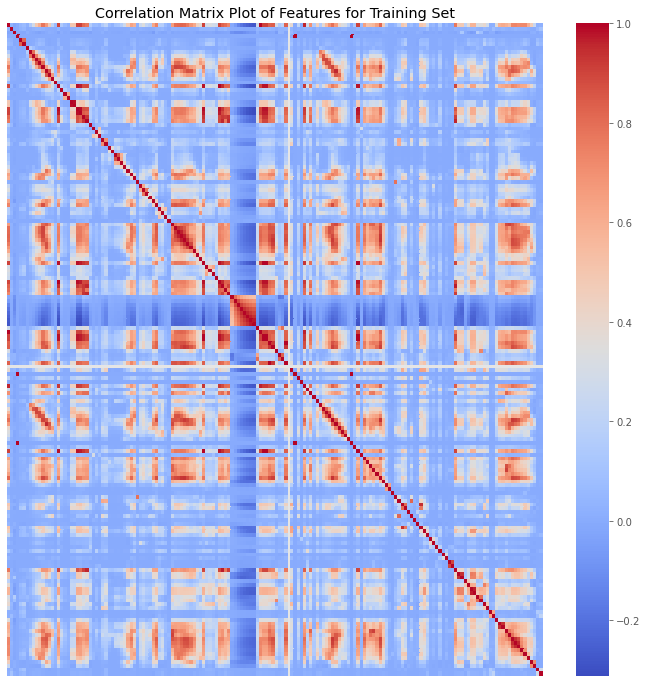

In [77]:
fit, axes = plt.subplots(figsize=(12, 12))
sns.heatmap(aps_train_X.corr(), cmap='coolwarm',
            xticklabels=False, yticklabels=False, ax=axes)
plt.title("Correlation Matrix Plot of Features for Training Set")
plt.show()

### 2.(b)-iv Pick $\lfloor{ \sqrt{170} \rfloor}$ features with highest CV , and make scatter plots and box plots for them.

In [78]:
num_feats = int(np.floor(np.sqrt(170)))
highCVfeats = coef_of_vari.sort_values(ascending=False)[:num_feats]
highCVfeats

cs_009    235.275644
cf_000    184.231557
co_000    183.947485
ad_000    183.846088
dh_000    114.984033
dj_000    109.646371
ag_000     91.877799
as_000     86.416184
ay_009     83.785365
az_009     76.967337
ak_000     74.526067
au_000     68.159986
ch_000     58.267743
dtype: float64

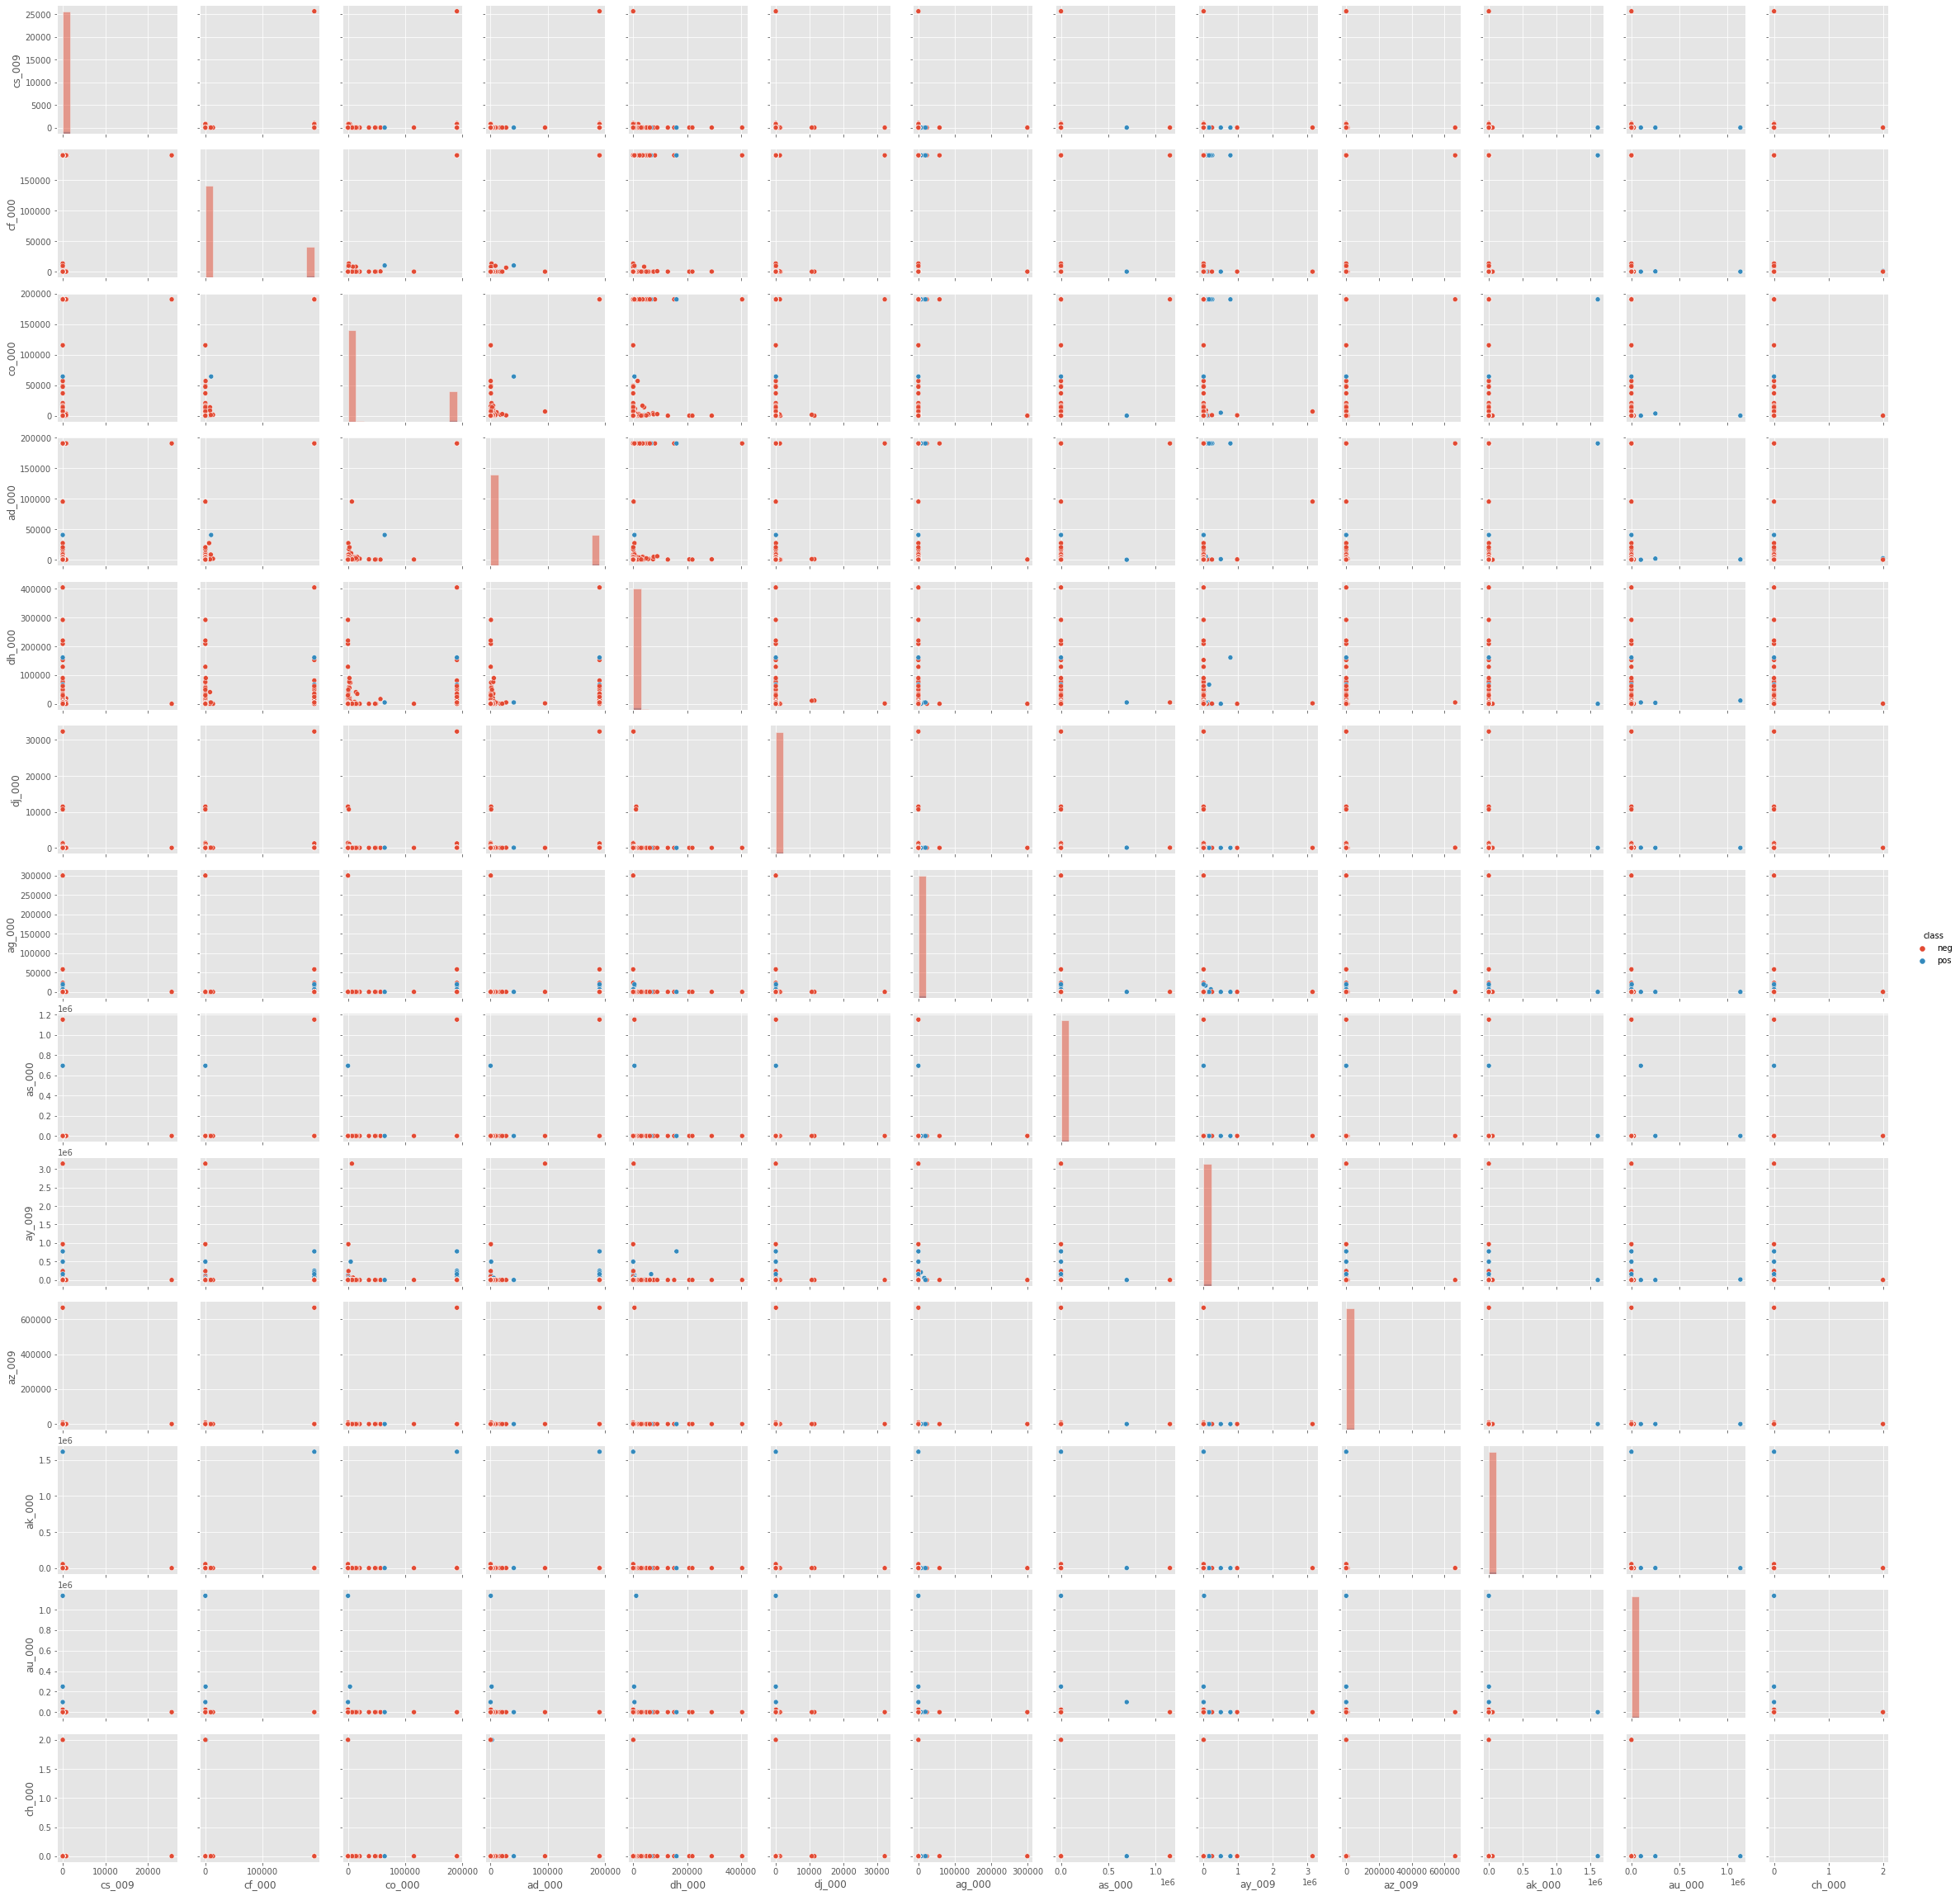

In [79]:
# highCVfeats.index.to_list()
"""
Note that I used a decimated samples here to draw the plot as the 60k samples
make the function seems run forever after upgrading the package in anconda...
"""
merged = aps_train_X[highCVfeats.index.to_list()].copy()
merged.loc[:, 'class'] = aps_train_Y
sns.pairplot(merged.sample(frac=0.1), hue='class', diag_kind='hist')
plt.show()

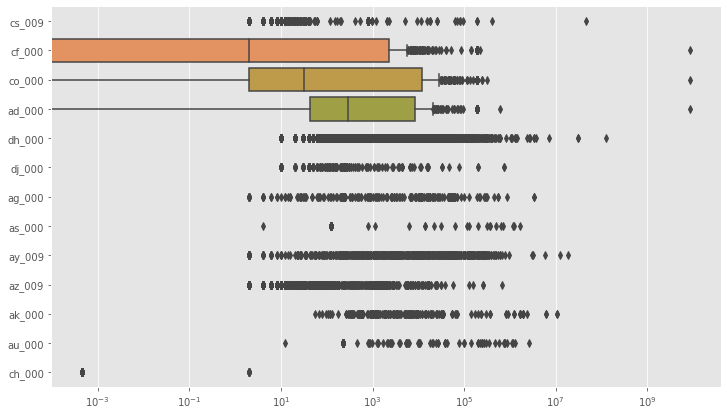

In [82]:
fig, axes = plt.subplots(figsize=(12, 7))
box = sns.boxplot(data=aps_train_X[highCVfeats.index.to_list()], orient='h', ax=axes)
box.set(xscale="log")
plt.show()

It's hard to draw a conclusion of significance of those features just by scatter plots. The imputation strategy with mean can be easily affected by an "outlier". Here I show the log scale in value to see the distributions.

### 2.(b)-v Determine the number of positive and negative data

In [41]:
aps_train_Y.value_counts()

neg    59000
pos     1000
Name: class, dtype: int64

In [42]:
aps_test_Y.value_counts()

neg    15625
pos      375
Name: class, dtype: int64

We can see that both training and test set are class-implalanced.

## 2.(c) Train a random forest to classify the data set. Do NOT compensate for class imbalance in the data set.

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, accuracy_score

"""
Doc reference；
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
"""

def modelSummary(ground_truth, predict, prob, title):
    conf_mat = confusion_matrix(ground_truth, predict)
    print("The confusion for {} set is \n{}".format(title, conf_mat))
    acc = accuracy_score(ground_truth, predict)
    print("The classification accuracy is %0.4f" % acc)
    fpr, tpr, thresholds = roc_curve(ground_truth, prob[:, 1], pos_label='pos')
    roc_auc = round(auc(fpr, tpr), 4)
    fig, axes = plt.subplots(figsize=(12, 7))
    axes.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
    axes.plot([0, 1], [0, 1], "--")
    axes.set_xlabel("False Positive Rate")
    axes.set_ylabel("True Positive Rate")
    axes.legend()
    axes.set_title("ROC curves of {} set".format(title))
    plt.show()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


The confusion for training set is 
[[58972    28]
 [  450   550]]
The classification accuracy is 0.9920


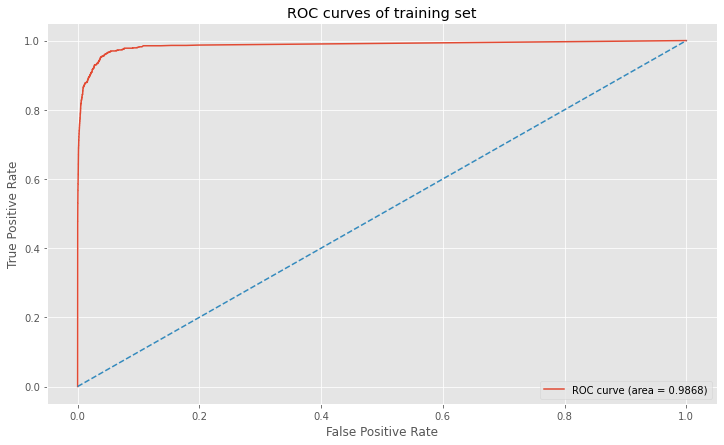

In [44]:
# build random forest model, imbalanced
RF_model = RandomForestClassifier(max_depth=5, 
                                  random_state=60000, 
                                  verbose=1, 
                                  oob_score=True)
RF_model.fit(aps_train_X, aps_train_Y)

# predict on dataset
train_Y_predict = RF_model.predict(aps_train_X)
train_Y_prob = RF_model.predict_proba(aps_train_X)

# get confusion matrix, ROC, AUC 
modelSummary(aps_train_Y, train_Y_predict, train_Y_prob, 'training')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


The confusion for test set is 
[[15612    13]
 [  180   195]]
The classification accuracy is 0.9879


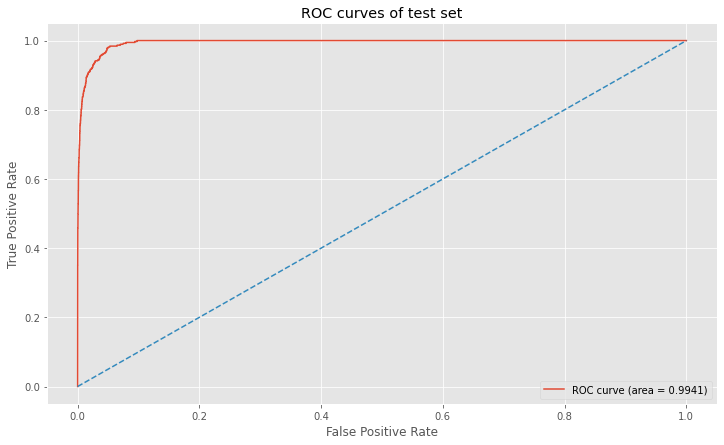

In [45]:
# predict on dataset
test_Y_predict = RF_model.predict(aps_test_X)
test_Y_prob = RF_model.predict_proba(aps_test_X)

# get confusion matrix, ROC, AUC 
modelSummary(aps_test_Y, test_Y_predict, test_Y_prob, 'test')

In [46]:
trainOOB_err = round(1 - RF_model.oob_score_, 4)
print("The Out of Bag Error of training set is %.4f"%trainOOB_err)
print("The test Error is %.4f"%round(1 - accuracy_score(aps_test_Y, test_Y_predict), 4))

The Out of Bag Error of training set is 0.0094
The test Error is 0.0121


## 2.(d) Research how class imbalance is addressed in random forests. Compensate for class imbalance in your random forest and repeat 2c.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


The confusion for training set is 
[[56562  2438]
 [   31   969]]
The classification accuracy is 0.9588


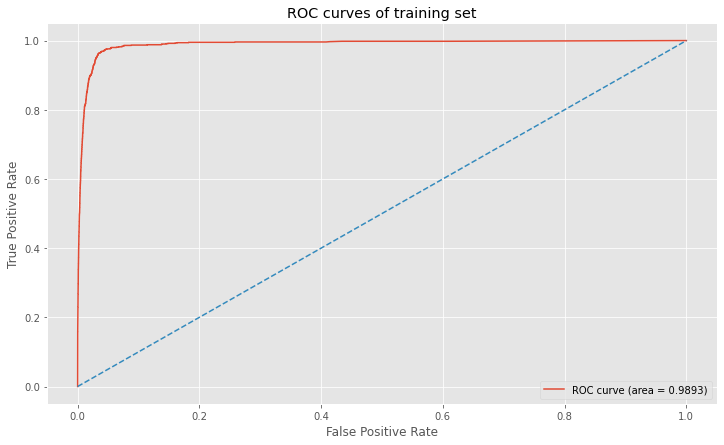

In [47]:
# build random forest model, balanced
RF_model = RandomForestClassifier(max_depth=5, 
                                  random_state=60000, 
                                  verbose=1, 
                                  oob_score=True,
                                  class_weight='balanced')
RF_model.fit(aps_train_X, aps_train_Y)

# predict on dataset
train_Y_predict = RF_model.predict(aps_train_X)
train_Y_prob = RF_model.predict_proba(aps_train_X)

# get confusion matrix, ROC, AUC 
modelSummary(aps_train_Y, train_Y_predict, train_Y_prob, 'training')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


The confusion for test set is 
[[14994   631]
 [   15   360]]
The classification accuracy is 0.9596


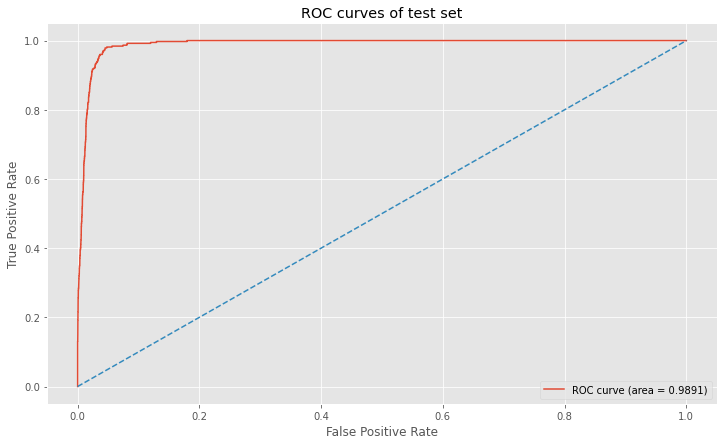

In [48]:
# predict on dataset
test_Y_predict = RF_model.predict(aps_test_X)
test_Y_prob = RF_model.predict_proba(aps_test_X)

# get confusion matrix, ROC, AUC 
modelSummary(aps_test_Y, test_Y_predict, test_Y_prob, 'test')

In [49]:
trainOOB_err = round(1 - RF_model.oob_score_, 4)
print("The Out of Bag Error of training set is %.4f"%trainOOB_err)
print("The test Error is %.4f"%round(1 - accuracy_score(aps_test_Y, test_Y_predict), 4))

The Out of Bag Error of training set is 0.0423
The test Error is 0.0404


For the test accuracy, we can see that the case without compensation has a better overall performance. But, as the 'neg' samples are significantly more than 'pos' samples, it is possible that the model tends to predict a sample as 'neg' to reach a higher accuracy. If we have a detail observation to confusion matrix, the compensated case (when `class_weight='balanced'`) has a remarkable better prediction for 'pos' class (195/375 v.s. 360/375).

## 2.(e) Model Trees using WEKA

In [50]:
# write new csv files for weka model to load
weka_train_path = '../data/weka_train.csv'
weka_test_path = '../data/weka_test.csv'

imputed_aps_train = aps_train_X.copy()
imputed_aps_train.loc[:, 'class'] = aps_train_Y
imputed_aps_test = aps_test_X.copy()
imputed_aps_test.loc[:, 'class'] = aps_test_Y

imputed_aps_train.to_csv(weka_train_path, index=False)
imputed_aps_test.to_csv(weka_test_path, index=False)

In [51]:
import weka.core.jvm as jvm
import javabridge
jvm.start()

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['/Users/wangruihao/opt/anaconda3/lib/python3.7/site-packages/javabridge/jars/rhino-1.7R4.jar', '/Users/wangruihao/opt/anaconda3/lib/python3.7/site-packages/javabridge/jars/runnablequeue.jar', '/Users/wangruihao/opt/anaconda3/lib/python3.7/site-packages/javabridge/jars/cpython.jar', '/Users/wangruihao/opt/anaconda3/lib/python3.7/site-packages/weka/lib/python-weka-wrapper.jar', '/Users/wangruihao/opt/anaconda3/lib/python3.7/site-packages/weka/lib/weka.jar']
DEBUG:weka.core.jvm:MaxHeapSize=default
DEBUG:weka.core.jvm:Package support disabled


In [52]:
"""
Doc reference:
https://fracpete.github.io/python-weka-wrapper/api.html
https://fracpete.github.io/python-weka-wrapper/#api
"""

from weka.classifiers import Classifier, Evaluation
from weka.core.converters import Loader
from weka.core.classes import Random
import weka.plot.classifiers as plcls

In [53]:
# load data and specify the column of label
weka_loader = Loader(classname="weka.core.converters.CSVLoader")
weka_train = weka_loader.load_file(weka_train_path)
weka_test = weka_loader.load_file(weka_test_path)
weka_train.class_is_last()
weka_test.class_is_last()

### Weka LMT model, 5-fold validation on training set

In [54]:
# create LMT model and do 5-fold croos-validation, this section takes extremely long time...
lmt = Classifier(classname='weka.classifiers.trees.LMT')
evl = Evaluation(weka_train)
evl.crossvalidate_model(classifier=lmt, data=weka_train, num_folds = 5, rnd=Random(60000))

In [55]:
# report confusion matrix
print(evl.confusion_matrix)

[[58823.   177.]
 [  304.   696.]]


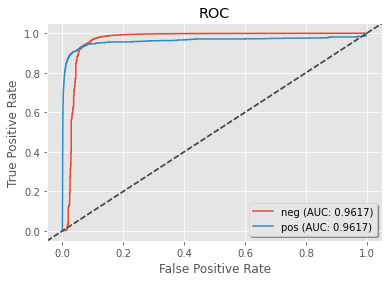

In [56]:
# plot ROC curve and get AUC
plcls.plot_roc(evl, class_index=[0, 1], wait=True)

In [57]:
# report details
print(evl.summary())
print(evl.class_details())


Correctly Classified Instances       59519               99.1983 %
Incorrectly Classified Instances       481                0.8017 %
Kappa statistic                          0.7391
Mean absolute error                      0.011 
Root mean squared error                  0.0821
Relative absolute error                 33.5878 %
Root relative squared error             64.1084 %
Total Number of Instances            60000     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.997    0.304    0.995      0.997    0.996      0.741    0.962     0.998     neg
                 0.696    0.003    0.797      0.696    0.743      0.741    0.962     0.741     pos
Weighted Avg.    0.992    0.299    0.992      0.992    0.992      0.741    0.962     0.993     



### Weka LMT model on test set

In [58]:
"""
Note that:
I reimplement the test process and use the modelSummary() function 
defined in previous section here as the evaluation.test_model keeps 
throw exceptions which cannot be resolved.
"""
# build the classifier with training data
lmt.build_classifier(weka_train)

weka_test_predict = []
weka_test_proba = []

# make prediction for each instance
for inst in weka_test:
    weka_test_predict.append(lmt.classify_instance(inst))
    weka_test_proba.append(lmt.distribution_for_instance(inst))
# convert to numpy array
weka_test_predict = np.array(weka_test_predict).astype('str')
weka_test_predict[weka_test_predict == '0.0'] = 'neg'
weka_test_predict[weka_test_predict == '1.0'] = 'pos'
weka_test_proba = np.array(weka_test_proba)

The confusion for test set is 
[[15579    46]
 [  108   267]]
The classification accuracy is 0.9904


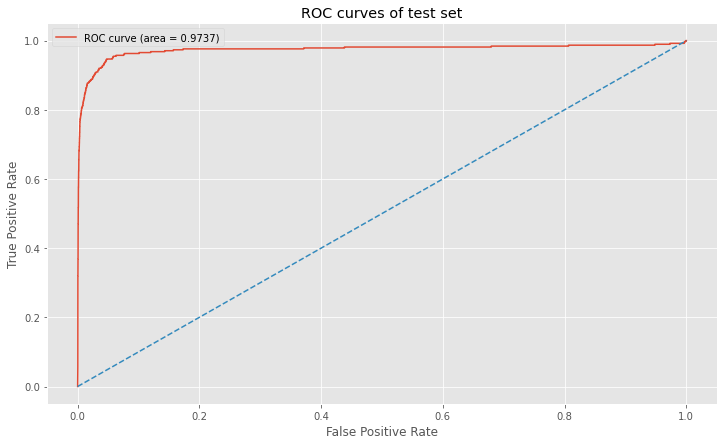

In [59]:
modelSummary(aps_test_Y, weka_test_predict, weka_test_proba, 'test')

## 2.(e) Use SMOTE

In [60]:
"""
Doc reference:
https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html
https://stackoverflow.com/questions/55591063/how-to-perform-smote-with-cross-validation-in-sklearn-in-python
"""
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold

In [61]:
# apply SMOTE within cross-validation
valid_err = []
splitter = StratifiedKFold(n_splits=5, random_state=60000, shuffle=True)
for train_idx, valid_idx in splitter.split(aps_train_X, aps_train_Y):
    # split training and validation set
    cur_train_X = aps_train_X.iloc[train_idx, :]
    cur_train_Y = aps_train_Y.iloc[train_idx]
    bi_cur_train_Y = cur_train_Y.replace({'neg' : 0.0, 'pos' : 1.0})
    cur_valid_X = aps_train_X.iloc[valid_idx, :]
    cur_valid_Y = aps_train_Y.iloc[valid_idx]
    # create smote instance
    smote = SMOTE(random_state=60000)
    # apply smote to train data rather than apply to both
    smote_trainX, smote_trainY = smote.fit_sample(cur_train_X, 
                                                  bi_cur_train_Y)
    smote_trainX.loc[:, 'class'] = smote_trainY.replace({0.0 : 'neg', 1.0 : 'pos'})
    cur_valid_X.loc[:, 'class'] = cur_valid_Y
    print('SMOTE finished...')
    # write to file and reload by weka package
    train_path = '../data/tmp_smote_train.csv'
    valid_path = '../data/tmp_smote_valid.csv'
    smote_trainX.to_csv(train_path, index=False)
    cur_valid_X.to_csv(valid_path, index=False)
    weka_train = weka_loader.load_file(train_path)
    weka_valid = weka_loader.load_file(valid_path)
    weka_train.class_is_last()
    print('Weka Model Starts...')
    weka_valid.class_is_last()
    # create weka LMT model
    lmt = Classifier(classname='weka.classifiers.trees.LMT')
    lmt.build_classifier(weka_train)
    evl = Evaluation(weka_train)
    evl.test_model(lmt, weka_valid)
    valid_err.append(evl.percent_correct)
    print("Cross Validation {} / 5 finished".format(len(valid_err)))

SMOTE finished...
Weka Model Starts...
Cross Validation 1 / 5 finished
SMOTE finished...
Weka Model Starts...
Cross Validation 2 / 5 finished
SMOTE finished...
Weka Model Starts...
Cross Validation 3 / 5 finished
SMOTE finished...
Weka Model Starts...
Cross Validation 4 / 5 finished
SMOTE finished...
Weka Model Starts...
Cross Validation 5 / 5 finished


In [62]:
[100 - err for err in valid_err]

[98.475,
 1.7750000000000057,
 1.8416666666666686,
 2.0833333333333286,
 1.61666666666666]

In [63]:
# SMOTE on entrie trainning set
smote_weka_trainX, smote_weka_trainY = smote.fit_sample(aps_train_X,
                                                       aps_train_Y.replace({0.0 : 'neg', 1.0 : 'pos'}))

# save SMOTE trainning set as CSV
smote_train_path = '../data/smote_weka_train.csv'
smote_weka_trainX.loc[:, 'class'] = smote_weka_trainY.replace({0.0 : 'neg', 1.0 : 'pos'})
smote_weka_trainX.to_csv(smote_train_path, index=False)

In [64]:
# build the classifier with training data (SMOTE)
weka_train = weka_loader.load_file(smote_train_path)
weka_train.class_is_last()

lmt.build_classifier(weka_train)

In [65]:
weka_train_predict = []
weka_train_proba = []

# make prediction for each instance
for inst in weka_train:
    weka_train_predict.append(lmt.classify_instance(inst))
    weka_train_proba.append(lmt.distribution_for_instance(inst))
# convert to numpy array
weka_train_predict = np.array(weka_train_predict).astype('str')
weka_train_predict[weka_train_predict == '0.0'] = 'neg'
weka_train_predict[weka_train_predict == '1.0'] = 'pos'
weka_train_proba = np.array(weka_train_proba)

The confusion for train set is 
[[58427   573]
 [  245 58755]]
The classification accuracy is 0.9931


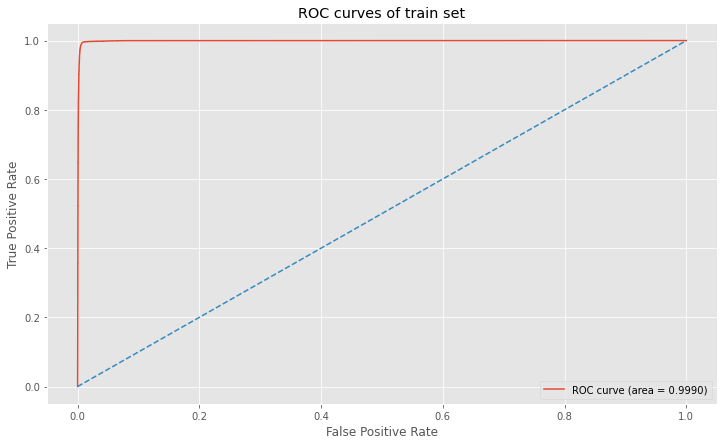

In [66]:
modelSummary(smote_weka_trainY.replace({0.0 : 'neg', 1.0 : 'pos'}), weka_train_predict, weka_train_proba, 'train')

In [67]:
weka_test_predict = []
weka_test_proba = []

# make prediction for each instance
for inst in weka_test:
    weka_test_predict.append(lmt.classify_instance(inst))
    weka_test_proba.append(lmt.distribution_for_instance(inst))
# convert to numpy array
weka_test_predict = np.array(weka_test_predict).astype('str')
weka_test_predict[weka_test_predict == '0.0'] = 'neg'
weka_test_predict[weka_test_predict == '1.0'] = 'pos'
weka_test_proba = np.array(weka_test_proba)

The confusion for test set is 
[[15102   523]
 [   61   314]]
The classification accuracy is 0.9635


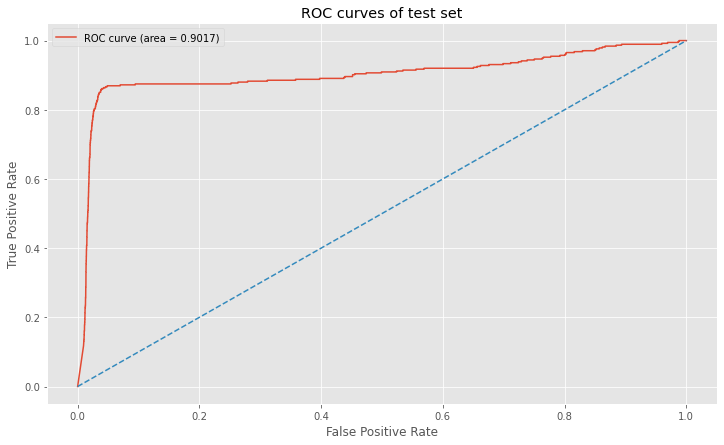

In [68]:
modelSummary(aps_test_Y, weka_test_predict, weka_test_proba, 'test')

By comparing the results of LMT model with/without SMOTE, we can see a degradation of ROC and AUC, which implies a overall performance. SInce our dataset is class imblanced, however, this might be a result of missclassification of negative, the majority class. If we observe the confusion matrix, we can see a better precision (267/375 v.s. 314/375) of positive class which is the minority in our dataset. That means SMOTE can really help to imporve the classification of minority class.

In [ ]:
jvm.stop()

===============================================================================

# 3. ISLR 6.8.3

**Ans:**

(a) **Steadily increase.** Along with the growth of $s$, the values of estimated coefficients will go from 0 to their OLS value. Thus, the traning RSS will steadily decrease.

(b) **Decrease initially, and then eventually start increasing in a U shape.** Along with the growth of $s$, the values of estimated coefficients will gradually go non-zero. That means the the numbre of predictors increases and the model becomes more flexible. This may lead to a over-fitting situation.

(c) **Steadily increase.** $\beta$s are almost all zero at the beginning. There is almost no variance at the beginning stage. After the model becoming flexible, the variance will goe up.

(d) **Steadily decrease.** Bias has a counter-tendency compare with variance as they form a trade-off.

(e) **Remains constant.** The irreducible erro is model independent.



# 4. ISLR 6.8.5


**Ans:**

(a) The Ridge Regression is to optimize the following value

$$
\min_{\hat{\beta_i}} \sum_{i=1}^{n}(y_i - \hat{\beta_0} - \sum_{j=1}^{p}\hat{\beta_j}x_j)^2 + \lambda \sum_{j=1}^{p}\hat{\beta_j}^2
$$

when the interception is zero, $n = p = 2$ and given settings, we have

$$
\min_{\hat{\beta_i}} [(y_1 - \hat{\beta}_1x_{11} - \hat{\beta}_2x_{12})^2 + (y_2 - \hat{\beta}_1x_{21} - \hat{\beta}_2x_{22})^2 + \lambda (\hat{\beta}_1^2 + \hat{\beta}_2^2)]
$$

(b) From the optimization above and given setting, we can find the expressions of $\hat{\beta_1}$ and $\hat{\beta_2}$ as

$$
\hat{\beta}_1 = \frac{x_1y_1 + x_2y_2 - \hat{\beta}_2(x_1^2 + x_2^2)}{\lambda + x_1^2 + x_2^2} \\
\hat{\beta}_2 = \frac{x_1y_1 + x_2y_2 - \hat{\beta}_1(x_1^2 + x_2^2)}{\lambda + x_1^2 + x_2^2}
$$

Such a symetric expression implies they are the same.


(c) For Lasso Regression, we have

$$
\min_{\hat{\beta_i}} (y_1 - \hat{\beta}_1x_{11} - \hat{\beta}_2x_{12})^2 + (y_2 - \hat{\beta}_1x_{21} - \hat{\beta}_2x_{22})^2 + \lambda (| \hat{\beta}_1 | + | \hat{\beta}_2 |)
$$

It's quite similar with expression but the regularization part is different.

(d) With the given setting, we can simplify the optimization term as
$$
\min_{\hat{\beta_i}} 2(y_1 - (\hat{\beta}_1 + \hat{\beta}_2)x_{11})^2
$$
That means our solutions should satisfy $\hat{\beta}_1 + \hat{\beta}_2 = \frac{y_1}{x_{11}}$. This a line parallel to the edge of Lasso diamond. Thus, there are many potential solutions and we cannot guarantee that $\beta_1$ and $\beta_2$ are equal.

# 5. ISLR 8.4.5

**Ans:**

For the majority polling, red samples has a larger number than grean samples. Thus, the result will be red.

For the average probability method, a mean of 0.45 will lead a prediction of green.


# 6. ISLR 9.7.3

In [144]:
sample_dict = {'X1' : [3, 2, 4, 1, 2, 4, 4], 
           'X2' : [4, 2, 4, 4, 1, 3, 1], 
           'Y' : ['red', 'red', 'red', 'red', 'blue', 'blue', 'blue']}
sample_df = pd.DataFrame.from_dict(sample_dict)

In [149]:
from sklearn.svm import SVC

"""
Doc Reference:
https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html
"""

# create svm model
clf = SVC(kernel='linear', C=10000)
clf.fit(sample_df.iloc[:, :-1], sample_df.iloc[:, -1])

SVC(C=10000, kernel='linear')

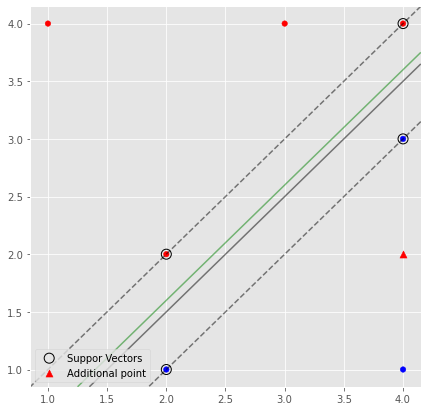

[0.99970703] [[-1.99941406  1.99941406]]


In [183]:
# plot graph
fig, ax = plt.subplots(figsize=(7, 7))

# scatter plot of sample points
ax.scatter(sample_df.iloc[:, 0], sample_df.iloc[:, 1], 
           c=sample_df.iloc[:, -1], s=30, 
           cmap=plt.cm.Paired)

# create a grid
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# hyperplane
lines1 = ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'], label="Decision Boundary")

# support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k', label="Suppor Vectors")

# a hyperplane that is not optimal
lines2 = ax.contour(XX, YY, Z - 0.2, colors='g', levels=[0], alpha=0.5,
           linestyles=['-'])

# point make the data NOT linear-separable
ax.scatter([4.0], [2.0], color='r', marker='^', s=50, label="Additional point")

ax.legend()
plt.show()

print(clf.intercept_, clf.coef_)

(b) The solid black lines is the hyperplane.

(c) We can see, the parameters are approximately:

$$
\beta_0 = 1, \beta_1 = -2, \beta_2 = 2 \\
\beta_0 + \beta_1 X_1 + \beta_2 X_2 > 0 \Rightarrow red, \\
otherwise, blue
$$

(d) The dash lines indicates the maximal margin

(e) The circeled ones are support vectors.

(f) The seventh point is far away from the maximal margin hyperplane. If it is on the edge of decision boundary, it will have effects but it does not.

(g) The solid green line.

(h) The new point marked as red triangle. This make the points form an XOR pattern which is not linear-separable.